# Basics

This example demonstrates the basics of operator learning in Continuity.

First, let's import the necessary modules.

In [1]:
import torch
import matplotlib.pyplot as plt
from continuity.operators import DeepONet
from continuity.data import OperatorDataset
from continuity.trainer import Trainer

In [2]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Operator

Assume we want to learn an operator

\begin{align}
G: U &\to V, \\
   u &\mapsto v,
\end{align}

that maps a function $u \in U$ to a function $v \in V$, where $U$ and $V$ are
function spaces.

In this example, we choose to learn the derivative operator

$$
G: u \mapsto \partial_x u.
$$

For simplicity, we map a single instance $u(x)=\sin(x)$ to its derivative
$v(y)=\cos(y)$ with $x, y\in \mathbb{R}$ on the interval $[-\pi, \pi]$.
Note that in case of the derivative, we have $x = y$, but in general the input and
output function domains can be different.

Let's start with defining $u$ and $v$ and visualize the functions.

In [3]:
# Input function u (some example)
u_func = lambda x: torch.sin(x)

# Target function v (the derivative of u)
v_func = lambda y: torch.cos(y)

# Domain size [-L, L]
L = torch.pi

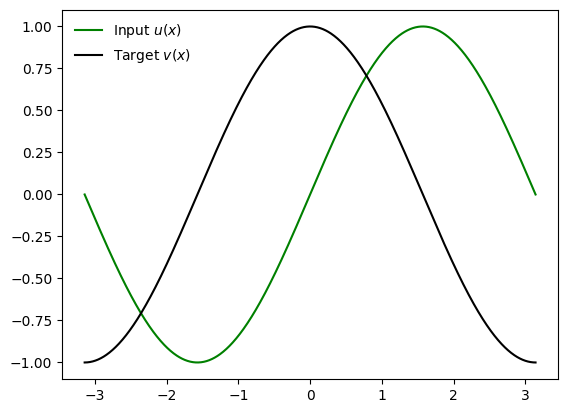

In [4]:
x = torch.linspace(-L, L, 1000)
plt.plot(x, u_func(x), "g-", label=r"Input $u(x)$")
plt.plot(x, v_func(x), "k-", label=r"Target $v(x)$")
plt.legend()
plt.show()

!!! note

    In these examples, we hide the code for visualization, but you can find it in the source code of this notebook.

## Discretization
Operator learning is about learning mappings between infinite dimensional spaces.
To work with infinite-dimensional objects numerically, we have to discretize
the input and output function somehow. In Continuity, this is done by point-wise
evaluation.

Let's probe $u$ at 32 sensors positions and $v$ in 100 evaluation points.

In [5]:
num_sensors = 32
x = torch.linspace(-L, L, num_sensors)
u = u_func(x)

num_evaluations = 100
y = torch.linspace(-L, L, num_evaluations)
v = v_func(y)

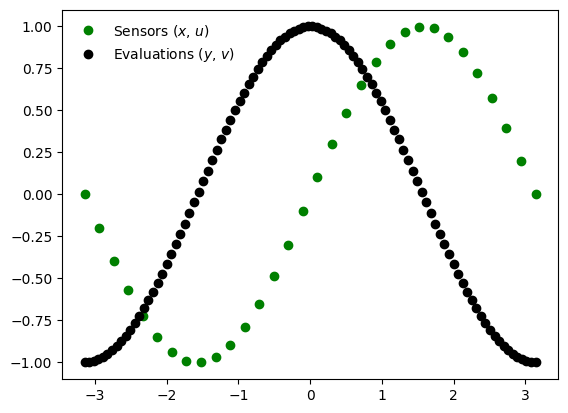

In [6]:
plt.plot(x, u, "go", label="Sensors ($x$, $u$)")
plt.plot(y, v, "ko", label="Evaluations ($y$, $v$)")
plt.legend()
plt.show()

## Dataset
Discretized functions can be collected in an `OperatorDataset` for
operator learning.

The `OperatorDataset` is a container of discretizations of input-output functions.
It contains tuples (`x`, `u`, `y`, `v`) of tensors, where every sample consists of

  - the sensor positions `x`,
  - the values `u` of the input function at the sensor positions,
  - the evaluation points `y`, and
  - the values `v` of the output functions at the evaluation points.

The corresponding tensors have the following shapes.

In [7]:
n_samples = 1
u_dim = x_dim = y_dim = v_dim = 1

x = x.reshape(n_samples, num_sensors, x_dim)
u = u.reshape(n_samples, num_sensors, u_dim)
y = y.reshape(n_samples, num_evaluations, y_dim)
v = v.reshape(n_samples, num_evaluations, v_dim)

dataset = OperatorDataset(x, u, y, v)

## Neural Operator

In order to learn the operator $G$ with a neural network, we can train a _neural operator_.

A neural operator $G_\theta$ takes an input function $u$, evaluated at sensor positions $x$,
and maps it to a function $v$ evaluated at (possibly different) evaluation points $y$, such that
$$
v(y) = G(u)(y) \approx G_\theta\left(x, u(x), y\right).
$$

In this example, we train a DeepONet, a common neural operator architecture
motivated by the universal approximation theorem for operators.

In [8]:
operator = DeepONet(shapes=dataset.shapes)

## Training

Let's train the neural operator! Continuity provides the `Trainer` class
which implements a default training loop for neural operators.
It is instantiated with an `Operator`, an optimizer (`Adam(lr=1e-3)` by default), 
and a loss function (`MSELoss` by default).

The `fit` method takes an `OperatorDataset` and trains the neural operator 
up to a given tolerance on the training data (but at most for a
given number of epochs, 1000 by default).

In [9]:
trainer = Trainer(operator)
trainer.fit(dataset, tol=3e-4)

Model parameters: 5872
Device: mps
Epoch 372:  loss/train = 2.9981e-04  (0.011 s/epoch)


## Evaluation

The mapping of the trained operator can be evaluated at arbitrary positions,
so let's plot the prediction of $G_\theta$ on a fine resolution along with
the target function.

In [10]:
y_plot = torch.linspace(-L, L, 1000).reshape(1, -1, 1)
v_pred = operator(x, u, y_plot)

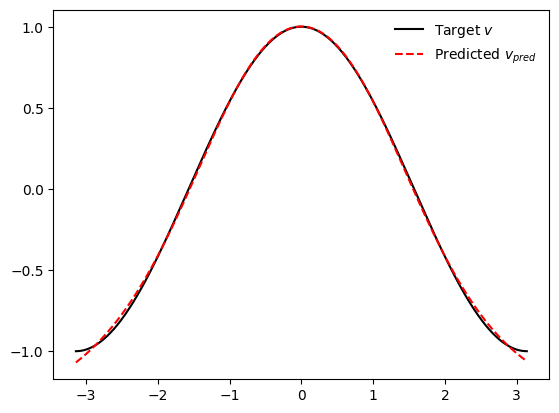

In [11]:

# Plot output and target function
plt.plot(y_plot.squeeze(), v_func(y_plot).squeeze(), "k-", label=r"Target $v$")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), "r--", label=r"Predicted $v_{pred}$")
plt.legend()
plt.show()

As you can see, the operator output (approximately) matches $v$, as desired.
That's the basics!